## 0. Installations, Imports and Helper Functions

In [1]:
!pip install torch
!pip install accelerate -U
!pip install livelossplot

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:

import flax
import flax.linen as nn
import torch
from torch.utils.data import Dataset, DataLoader
import os
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import itertools
import random
import numpy as np
import optax
import math
from livelossplot import PlotLosses


In [3]:
# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if os.environ["COLAB_GPU"] and int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()
else:
    print("Only CPU accelerator is connected.")

# https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html#gpu-memory-allocation
# Avoid GPU memory allocation to be done by JAX.
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

a GPU is connected.


## 1. Load Data


Load the data from text files

In [4]:
class NguniDataset(Dataset):
    def __init__(self, data, seq_length, special_tokens):
        chars = sorted(list(set(data)))
        self.char2idx = {char: idx for idx, char in enumerate(chars)}
        self.char2idx.update({token: len(self.char2idx) for token in special_tokens})
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}
        self.data = [self.char2idx[char] for char in data]
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx + self.seq_length]
        target_seq = self.data[idx + 1:idx + self.seq_length + 1]
        return torch.tensor(input_seq), torch.tensor(target_seq)

In [5]:
# Load Nguni language data
def load_nguni_data(file_path):
    with open(file_path, 'r') as f:
        text = f.read()
    return text

In [6]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/My Drive/data/'
else:
    base_path = './LMDatasets/'


train_data_path = os.path.join(base_path, 'nchlt_text.nr.train')
val_data_path = os.path.join(base_path, 'nchlt_text.nr.valid')
test_data_path = os.path.join(base_path, 'nchlt_text.nr.test')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Multihead Attention

In [7]:
class SequenceToQKV(nn.Module):
  output_size: int

  @nn.compact
  def __call__(self, X):
    initializer = nn.initializers.variance_scaling(scale=0.5, mode="fan_in", distribution="truncated_normal")

    # this can also be one layer, how do you think you would do it?
    q_layer = nn.Dense(self.output_size, kernel_init=initializer)
    k_layer = nn.Dense(self.output_size, kernel_init=initializer)
    v_layer = nn.Dense(self.output_size, kernel_init=initializer)

    Q = q_layer(X)
    K = k_layer(X)
    V = v_layer(X)

    return Q, K, V

In [8]:
def scaled_dot_product_attention(query, key, value, mask=None):
    d_k = key.shape[-1]
    T_k = key.shape[-2]
    T_q = query.shape[-2]
    logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
    scaled_logits = logits / jnp.sqrt(d_k)

    if mask is not None:
        scaled_logits = jnp.where(mask[:T_q, :T_k], scaled_logits, -jnp.inf)

    attention_weights = jax.nn.softmax(scaled_logits, axis=-1)
    attention = jnp.matmul(attention_weights, value)
    return attention, attention_weights

In [9]:
class MultiHeadAttention(nn.Module):
  num_heads: int
  d_m: int

  def setup(self):
    self.sequence_to_qkv = SequenceToQKV(self.d_m)
    initializer = nn.initializers.variance_scaling(
        scale=0.5, mode="fan_in", distribution="truncated_normal")
    self.Wo = nn.Dense(self.d_m, kernel_init=initializer)

  def __call__(self, X=None, Q=None, K=None, V=None, mask=None, return_weights=False):
    if None in [Q, K, V]:
      assert not X is None, "X has to be provided if either Q,K,V not provided"

      # project all data to Q, K, V
      Q, K, V = self.sequence_to_qkv(X)

    # get the batch size, sequence length and embedding size
    B, T, d_m = K.shape

    # calculate heads embedding size (d_m/N)
    head_size = d_m // self.num_heads

    # B,T,d_m -> B, T, N, dm//N -> B, N, T, dm//N
    q_heads = Q.reshape(B, -1, self.num_heads, head_size).swapaxes(1, 2)
    k_heads = K.reshape(B, -1, self.num_heads, head_size).swapaxes(1, 2)
    v_heads = V.reshape(B, -1, self.num_heads, head_size).swapaxes(1, 2)

    attention, attention_weights = scaled_dot_product_attention(
        q_heads, k_heads, v_heads, mask
    )

    # (B, nh, T, hs) -> (B, T, nh, hs) -> (B, T, d_m) - re-assemble all head outputs
    attention = attention.swapaxes(1, 2).reshape(B, -1, d_m)

    # apply Wo
    X_new = self.Wo(attention)

    if return_weights:
      return X_new, attention_weights
    else:
      return X_new

# Transformer Model:

In [10]:
class AddNorm(nn.Module):
  """A block that impliments the add and norm block"""

  @nn.compact
  def __call__(self, x, processed_x):

    added = x + processed_x
    normalised = nn.LayerNorm(reduction_axes=-1, use_scale=True, use_bias=True)
    return normalised(added)

In [11]:
class FeedForwardBlock(nn.Module):
  """A 2-layer MLP which widens then narrows the input."""
  widening_factor: int = 4
  init_scale: float = 0.25

  @nn.compact
  def __call__(self, x):
    d_m = x.shape[-1]
    layer1_size = self.widening_factor * d_m

    initializer = nn.initializers.variance_scaling(
        scale=self.init_scale, mode='fan_in', distribution='truncated_normal',
    )
    layer1 = nn.Dense(layer1_size, kernel_init=initializer)
    layer2 = nn.Dense(d_m, kernel_init=initializer)

    x = jax.nn.gelu(layer1(x))
    x = layer2(x)
    return x

In [12]:
class DecoderBlock(nn.Module):
  """
  Transformer decoder block.

  Args:
    num_heads: The number of heads to be used in the MHA block.
    d_m: Token embedding size
    widening factor: The size of the hidden layer will be d_m * widening_factor.
  """

  num_heads: int
  d_m: int
  widening_factor: int = 4

  def setup(self):
    self.mha = MultiHeadAttention(self.num_heads, self.d_m)
    self.add_norm1 = AddNorm()
    self.add_norm2 = AddNorm()
    self.MLP = FeedForwardBlock(widening_factor=self.widening_factor)

  def __call__(self, X, mask=None, return_att_weight=True):
    """
    Args:
      X: Batch of tokens being fed into the decoder, with shape [B, T_decoder, d_m]
      mask [optional, default=None]: Mask to be applied, with shape [T_decoder, T_decoder].
      return_att_weight [optional, default=True]: Whether to return the attention weights.
    """

    attention, attention_weights_1 = self.mha(X, mask=mask, return_weights=True)

    X = self.add_norm1(X, attention)

    projection = self.MLP(X)
    X = self.add_norm2(X, projection)

    return (X, attention_weights_1) if return_att_weight else X

In [13]:
def return_frequency_pe_matrix(token_sequence_length, token_embedding):

  assert token_embedding % 2 == 0, "token_embedding should be divisible by two"

  P = jnp.zeros((token_sequence_length, token_embedding))
  positions = jnp.arange(0, token_sequence_length)[:, jnp.newaxis]

  i = jnp.arange(0, token_embedding, 2)
  frequency_steps = jnp.exp(i * (-math.log(10000.0) / token_embedding))
  frequencies = positions * frequency_steps

  P = P.at[:, 0::2].set(jnp.sin(frequencies))
  P = P.at[:, 1::2].set(jnp.cos(frequencies))

  return P

In [14]:
class LLM(nn.Module):
  """
  Transformer encoder consisting of several layers of decoder blocks.

  Args:
    num_heads: The number of heads to be used in the MHA block.
    num_layers: The number of decoder blocks to be used.
    d_m: Token embedding size
    vocab_size: The size of the vocabulary
    widening_factor: The size of the hidden layer will be d_m * widening_factor.
  """
  num_heads: int
  num_layers: int
  d_m: int
  vocab_size: int
  widening_factor: int = 4

  def setup(self):
    self.blocks = [
        DecoderBlock(self.num_heads, self.d_m, self.widening_factor)
        for _ in range(self.num_layers)
    ]
    self.embedding = nn.Embed(num_embeddings=self.vocab_size, features=self.d_m) # convert tokens to embedding
    self.pred_layer = nn.Dense(self.vocab_size)

  def __call__(self, X, mask=None, return_att_weights=False):
    """
    Args:
      X: Batch of tokens being fed into the decoder, with shape [B, T_decoder, d_m]
      mask [optional, default=None]: Mask to be applied, with shape [T_decoder, T_decoder].
      return_att_weight [optional, default=True]: Whether to return the attention weights.
    """

    # convert a token id to a d_m dimensional vector
    X = self.embedding(X)
    sequence_len = X.shape[-2]
    positions = return_frequency_pe_matrix(sequence_len, self.d_m)
    X = X + positions

    if return_att_weights:
        att_weights = []
    block_n = 0
    for block in self.blocks:
        out = block(X, mask, return_att_weights)
        if return_att_weights:
            X = out[0]
            att_weights.append(out[1])
        else:
            X = out

    # apply a linear layer and softmax to calculate our logits over tokens
    logits = nn.log_softmax(self.pred_layer(X))

    return (
        logits if not return_att_weights else (logits, jnp.array(att_weights).swapaxes(0, 1))
    )

In [15]:
def sequence_loss_fn(logits, targets):
  """Compute the loss on data wrt params."""
  target_labels = jax.nn.one_hot(targets, VOCAB_SIZE)
  print(logits.shape,target_labels.shape)
  assert logits.shape == target_labels.shape
  mask = jnp.greater(targets, 0)
  loss = -jnp.sum(target_labels * jax.nn.log_softmax(logits), axis=-1)
  loss = jnp.sum(loss * mask) / jnp.sum(mask)

  return loss

In [16]:
# @title Run me to test your code
VOCAB_SIZE = 25670
targets = jnp.array([[0, 2, 0]])
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [1, 3, VOCAB_SIZE])
loss = sequence_loss_fn(X, targets)
real_loss = jnp.array(10.966118)
assert jnp.allclose(real_loss, loss), "Not returning the correct value"
print("It seems correct. Look at the answer below to compare methods.")

(1, 3, 25670) (1, 3, 25670)
It seems correct. Look at the answer below to compare methods.


# Training

In [23]:

class CharBasedAsciiDatasetForLLM:
    """In-memory dataset of a single-file ASCII dataset for language-like model."""

    def __init__(self, path: str, batch_size: int, sequence_length: int):
        """Load a single-file ASCII dataset in memory."""
        self._batch_size = batch_size

        with open(path, "r") as f:
            corpus = f.read()

        # Tokenize by splitting the text into characters
        characters = list(corpus)
        self.vocab_size = len(set(characters))  # Number of unique characters

        # Create a mapping from characters to unique IDs
        self.char_to_id = {char: i for i, char in enumerate(set(characters))}

        # Store the inverse mapping from IDs to characters
        self.id_to_char = {i: char for char, i in self.char_to_id.items()}

        # Convert the characters in the corpus to their corresponding IDs
        corpus = np.array([self.char_to_id[char] for char in characters]).astype(np.int32)

        crop_len = sequence_length + 1
        num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
        if ragged:
            corpus = corpus[:-ragged]
        corpus = corpus.reshape([-1, crop_len])

        if num_batches < 10:
            raise ValueError(
                f"Only {num_batches} batches; consider a shorter "
                "sequence or a smaller batch."
            )

        self._ds = CharBasedAsciiDatasetForLLM._infinite_shuffle(
            corpus, batch_size * 10
        )

    def __iter__(self):
        return self

    def __next__(self):
        """Yield next mini-batch."""
        batch = [next(self._ds) for _ in range(self._batch_size)]
        batch = np.stack(batch)
        # Create the language modeling observation/target pairs.
        return dict(
            input=batch[:, :-1], target=batch[:, 1:]
        )

    def ids_to_chars(self, ids):
        """Convert a sequence of character IDs to characters."""
        return [self.id_to_char[id] for id in ids]

    @staticmethod
    def _infinite_shuffle(iterable, buffer_size):
        """Infinitely repeat and shuffle data from iterable."""
        ds = itertools.cycle(iterable)
        buf = [next(ds) for _ in range(buffer_size)]
        random.shuffle(buf)
        while True:
            item = next(ds)
            idx = random.randint(0, buffer_size - 1)  # Inclusive.
            result, buf[idx] = buf[idx], item
            yield result


In [30]:
# sample and look at the data
batch_size = 2
seq_length = 32

train_dataset = CharBasedAsciiDatasetForLLM(train_data_path, batch_size, seq_length)
batch = next(train_dataset)

for obs, target in zip(batch["input"], batch["target"]):
    print("-" * 10, "Input", "-" * 11)
    print("CHAR:", ' '.join(train_dataset.ids_to_chars(obs)))
    print("ASCII:", obs)
    print("-" * 10, "Target", "-" * 10)
    print("CHAR:", ' '.join(train_dataset.ids_to_chars(target)))
    print("ASCII:", target)

print(f"\n Total vocabulary size: {train_dataset.vocab_size}")


---------- Input -----------
CHAR:   i f o r o m o   l e s i b a w o   e k h a s i n i   e l i l a
ASCII: [21  7  3  5 66  5 52  5 21 13 73 14  7 60 69 68  5 21 73  0 32 69 14  7
 38  7 21 73 13  7 13 69]
---------- Target ----------
CHAR: i f o r o m o   l e s i b a w o   e k h a s i n i   e l i l a n
ASCII: [ 7  3  5 66  5 52  5 21 13 73 14  7 60 69 68  5 21 73  0 32 69 14  7 38
  7 21 73 13  7 13 69 38]
---------- Input -----------
CHAR: g o m b a n a   u m u m e t h e   i l w a z i   e l i q a k a t
ASCII: [81  5 52 60 69 38 69 21 80 52 80 52 73 74 32 73 21  7 13 68 69 59  7 21
 73 13  7 41 69  0 69 74]
---------- Target ----------
CHAR: o m b a n a   u m u m e t h e   i l w a z i   e l i q a k a t h
ASCII: [ 5 52 60 69 38 69 21 80 52 80 52 73 74 32 73 21  7 13 68 69 59  7 21 73
 13  7 41 69  0 69 74 32]

 Total vocabulary size: 110


In [17]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O input.txt

class WordBasedAsciiDatasetForLLM:
    """In-memory dataset of a single-file ASCII dataset for language-like model."""

    def __init__(self, path: str, batch_size: int, sequence_length: int):
        """Load a single-file ASCII dataset in memory."""
        self._batch_size = batch_size

        with open(path, "r") as f:
            corpus = f.read()

        # Tokenize by splitting the text into words
        words = corpus.split()
        self.vocab_size = len(set(words))  # Number of unique words

        # Create a mapping from words to unique IDs
        self.word_to_id = {word: i for i, word in enumerate(set(words))}

        # Store the inverse mapping from IDs to words
        self.id_to_word = {i: word for word, i in self.word_to_id.items()}

        # Convert the words in the corpus to their corresponding IDs
        corpus = np.array([self.word_to_id[word] for word in words]).astype(np.int32)

        crop_len = sequence_length + 1
        num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
        if ragged:
            corpus = corpus[:-ragged]
        corpus = corpus.reshape([-1, crop_len])

        if num_batches < 10:
            raise ValueError(
                f"Only {num_batches} batches; consider a shorter "
                "sequence or a smaller batch."
            )

        self._ds = WordBasedAsciiDatasetForLLM._infinite_shuffle(
            corpus, batch_size * 10
        )

    def __iter__(self):
        return self

    def __next__(self):
        """Yield next mini-batch."""
        batch = [next(self._ds) for _ in range(self._batch_size)]
        batch = np.stack(batch)
        # Create the language modeling observation/target pairs.
        return dict(
            input=batch[:, :-1], target=batch[:, 1:]
        )

    def ids_to_words(self, ids):
        """Convert a sequence of word IDs to words."""
        return [self.id_to_word[id] for id in ids]

    @staticmethod
    def _infinite_shuffle(iterable, buffer_size):
        """Infinitely repeat and shuffle data from iterable."""
        ds = itertools.cycle(iterable)
        buf = [next(ds) for _ in range(buffer_size)]
        random.shuffle(buf)
        while True:
            item = next(ds)
            idx = random.randint(0, buffer_size - 1)  # Inclusive.
            result, buf[idx] = buf[idx], item
            yield result


--2024-08-20 13:09:24--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2024-08-20 13:09:24 (47.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [29]:
# sample and look at the data
batch_size = 2
seq_length = 32
#train_dataset = WordBasedAsciiDatasetForLLM(train_data_path, batch_size, seq_length)
train_dataset = WordBasedAsciiDatasetForLLM(train_data_path, batch_size, seq_length)
batch = next(train_dataset)

for obs, target in zip(batch["input"], batch["target"]):
    print("-" * 10, "Input", "-" * 11)
    print("TEXT:", ' '.join(train_dataset.ids_to_words(obs)))
    print("ASCII:", obs)
    print("-" * 10, "Target", "-" * 10)
    print("TEXT:", ' '.join(train_dataset.ids_to_words(target)))
    print("ASCII:", target)

print(f"\n Total vocabulary size: {train_dataset.vocab_size}")

VOCAB_SIZE = train_dataset.vocab_size

---------- Input -----------
TEXT: engingene ngalo. Mina, njengelunga le-GeMS, ngikatelelekile ukubhadela imali yenyanga ku-GeMS. Mina namkha engibondlako akekho namunye ongumdlalifa wesinye isiKimu sezokwelapha esitlolisiweko. Ngizakwazisa isikimu ngamanye namanye amatjhuguluko emaphilweni wengibondlako namkha ngobujamo babo, njengombana kufunwa
ASCII: [100922 119673  50335    551  79225  51778 103534 114503  67206 111547
  68748  96433  36086  68406  41968 110881  64250  25518  15542 123461
 100460 110517  13601 117055  44600  62575  47680  96433 109578   3320
  38737 110673]
---------- Target ----------
TEXT: ngalo. Mina, njengelunga le-GeMS, ngikatelelekile ukubhadela imali yenyanga ku-GeMS. Mina namkha engibondlako akekho namunye ongumdlalifa wesinye isiKimu sezokwelapha esitlolisiweko. Ngizakwazisa isikimu ngamanye namanye amatjhuguluko emaphilweni wengibondlako namkha ngobujamo babo, njengombana kufunwa ngaphakathi
ASCII: [119673  50335    551  79225  51778 103534 114503  67206 

In [19]:
import functools

@functools.partial(jax.jit, static_argnums=(3, 4))
def train_step(params, optimizer_state, batch, apply_fn, update_fn):
  def loss_fn(params):
    T = batch['input'].shape[1]
    logits = apply_fn(params, batch['input'], jnp.tril(np.ones((T, T))))
    loss = sequence_loss_fn(logits, batch['target'])
    return loss

  loss, gradients = jax.value_and_grad(loss_fn)(params)
  updates, optimizer_state = update_fn(gradients, optimizer_state)
  params = optax.apply_updates(params, updates)
  return params, optimizer_state, loss

In [20]:
# all hyperparameters
d_model = 128
num_heads = 4
num_layers = 1
widening_factor = 2
LR = 2e-3
batch_size = 32
seq_length = 64

# set up the data
train_dataset = WordBasedAsciiDatasetForLLM(train_data_path, batch_size, seq_length)
vocab_size = train_dataset.vocab_size
batch = next(train_dataset)

rng = jax.random.PRNGKey(42)

key = jax.random.PRNGKey(42)
# initialise model
llm = LLM(num_heads=num_heads, num_layers=num_layers, d_m=d_model, vocab_size=vocab_size, widening_factor=widening_factor)
mask = jnp.tril(np.ones((batch['input'].shape[1], batch['input'].shape[1])))
params = llm.init(key, batch['input'], mask)

# set up the optimiser
optimizer = optax.adam(LR, b1=0.9, b2=0.99)
optimizer_state = optimizer.init(params)

In [31]:
# all hyperparameters
d_model = 128
num_heads = 4
num_layers = 1
widening_factor = 2
LR = 2e-3
batch_size = 32
seq_length = 64

# set up the data
train_dataset = CharBasedAsciiDatasetForLLM(train_data_path, batch_size, seq_length)
vocab_size = train_dataset.vocab_size
batch = next(train_dataset)

rng = jax.random.PRNGKey(42)

key = jax.random.PRNGKey(42)
# initialise model
llm = LLM(num_heads=num_heads, num_layers=num_layers, d_m=d_model, vocab_size=vocab_size, widening_factor=widening_factor)
mask = jnp.tril(np.ones((batch['input'].shape[1], batch['input'].shape[1])))
params = llm.init(key, batch['input'], mask)

# set up the optimiser
optimizer = optax.adam(LR, b1=0.9, b2=0.99)
optimizer_state = optimizer.init(params)

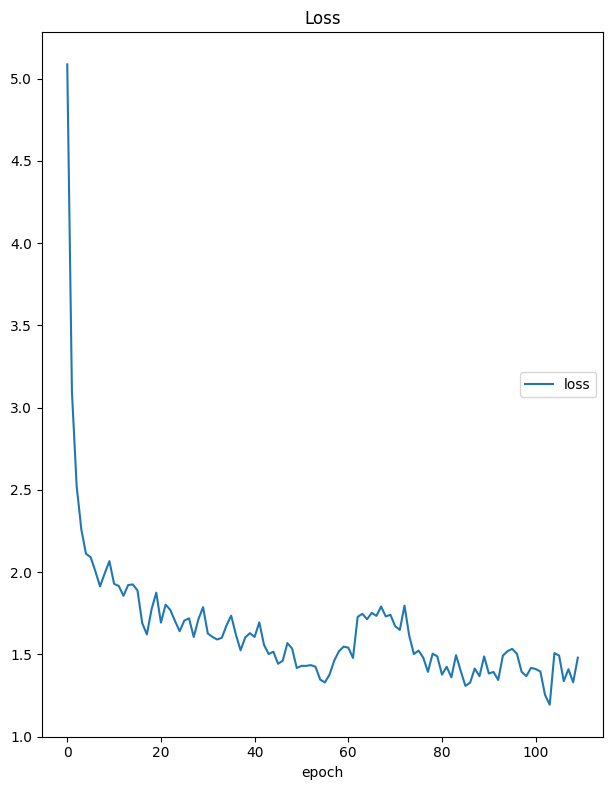

Loss
	loss             	 (min:    1.195, max:    5.087, cur:    1.480)


In [32]:
plotlosses = PlotLosses()

MAX_STEPS = 3500
LOG_EVERY = 32
losses = []
VOCAB_SIZE = train_dataset.vocab_size

# Training loop
for step in range(MAX_STEPS):
    batch = next(train_dataset)
    params, optimizer_state, loss = train_step(
        params, optimizer_state, batch, llm.apply, optimizer.update)
    losses.append(loss)
    if step % LOG_EVERY == 0:
        loss_ = jnp.array(losses).mean()
        plotlosses.update(
            {
                "loss": loss_,
            }
        )
        plotlosses.send()
        losses = []